# IMPORT

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from tqdm import tqdm
from torchsummary import summary

%matplotlib inline

# Загрузка данных

In [2]:
# Определяем на чем у нас будут производиться вычисления (cuda/cpu)
device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')  
device

device(type='cuda', index=0)

In [5]:
# необходимо разпаковать датасет в окружение, делается это так:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Flowers.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/dataset')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#функция для вывода изображений
def image_shower(images, labels, n=4):
    plt.figure(figsize=(12, 12))
    for i, image in enumerate(images[:n]):
        plt.subplot(n, n, i + 1)
        image = image/ 2 + 0.5
        plt.imshow(image.numpy().transpose((1, 2, 0)).squeeze())
    print("Real Labels: ", ' '.join('%5s' % classes[label] for label in labels[:n]))
#имена классов
classes = ("Aster", "Daisy", "Iris", "Lavender", "Lily", "Marigold", "Orchid", "Poppy", "Rose", "Sunflowers")

#путь до датасета
PATH = "/content/dataset/Flower Classification V2/V2/"

# Обработка данных

In [ ]:
# зададим какие преобразования необходимо сделать с каждым изображением
batch_size=40

transform = transforms.Compose(
    [transforms.Resize((64,64)),  #изменим размер изображений
     transforms.ToTensor(),   #переведем в формат который необходим нейронной сети - тензор
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]) # проведем нормализацию изображения

#загружаем тренировочный и тестовый датасеты
trainset = torchvision.datasets.ImageFolder(os.path.join(PATH, "Training Data"), transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, num_workers=0, shuffle=True)

testset = torchvision.datasets.ImageFolder(os.path.join(PATH, "Testing Data"), transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, num_workers=0, shuffle=True)


Real Labels:  Daisy Marigold Lavender Marigold


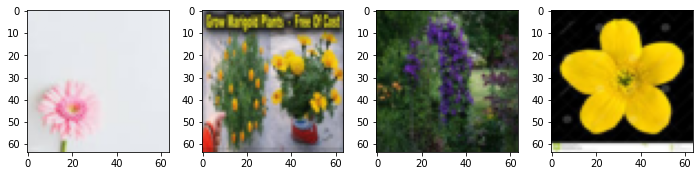

In [ ]:
#Проверим как работает наш загрузчик и посмотрим на парочку изображений
images, labels = next(iter(trainloader))
image_shower(images, labels)

In [ ]:
print(images.shape)
images=torch.squeeze(images)
print(images.shape)

torch.Size([40, 3, 64, 64])
torch.Size([40, 3, 64, 64])


# Архитектура нейронки 1

In [ ]:
# Инициализация модели
class MyNet1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,5)
        self.conv2 = nn.Conv2d(32,64,3)
        self.conv3 = nn.Conv2d(64,64,3)

        self.flatten = nn.Flatten()
        self.act = nn.LeakyReLU(0.2)        
        self.maxpool = nn.MaxPool2d(2,2)
        self.adaptivepool = nn.AdaptiveAvgPool2d((1,1))

        self.linear1 = nn.Linear(64,32)
        self.linear2 = nn.Linear(32,10)


    def forward(self, x):
      x=self.conv1(x)
      x=self.act(x)
      x=self.maxpool(x)

      x=self.conv2(x)
      x=self.act(x)
      x=self.maxpool(x)

      x=self.conv3(x)
      x=self.act(x)
      x=self.adaptivepool(x)

      x=self.flatten(x)
      x=self.linear1(x)
      x=self.act(x)
      x=self.linear2(x)

      return x

In [ ]:
net = MyNet1()
net.to(device)
summary(net,(3,64,64),batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [40, 32, 60, 60]           2,432
         LeakyReLU-2           [40, 32, 60, 60]               0
         MaxPool2d-3           [40, 32, 30, 30]               0
            Conv2d-4           [40, 64, 28, 28]          18,496
         LeakyReLU-5           [40, 64, 28, 28]               0
         MaxPool2d-6           [40, 64, 14, 14]               0
            Conv2d-7           [40, 64, 12, 12]          36,928
         LeakyReLU-8           [40, 64, 12, 12]               0
 AdaptiveAvgPool2d-9             [40, 64, 1, 1]               0
          Flatten-10                   [40, 64]               0
           Linear-11                   [40, 32]           2,080
        LeakyReLU-12                   [40, 32]               0
           Linear-13                   [40, 10]             330
Total params: 60,266
Trainable params: 

# Обечение архитектуры 1

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

learning_rate = 0.0001

optimizer = torch.optim.Adam(net.parameters(),learning_rate)

epoches = 10

In [ ]:
loss_list=[]
for epoch in range(epoches):  # многократное прохождение по набору данных
    
    running_loss = 0.0
    loss_val = 0.0
    

    for i, data in enumerate(trainloader, 0):
        # получаем входные данные; данные - это список [inputs, labels].
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиенты параметров
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # вывести статистику обучения
        running_loss += loss.item()
        loss_val += loss.item()
        if i % 50 == 49:    # вывести каждые 2000 images
            print(f'[{epoch + 1}, {(i + 1)*batch_size:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0
    loss_list.append(loss_val/len(trainloader))

print('Finished Training')

[1,  2000] loss: 1.749
[1,  4000] loss: 1.725
[1,  6000] loss: 1.685
[1,  8000] loss: 1.744
[1, 10000] loss: 1.697
[1, 12000] loss: 1.685
[1, 14000] loss: 1.687
[2,  2000] loss: 1.693
[2,  4000] loss: 1.728
[2,  6000] loss: 1.692
[2,  8000] loss: 1.669
[2, 10000] loss: 1.668
[2, 12000] loss: 1.652
[2, 14000] loss: 1.635
[3,  2000] loss: 1.657
[3,  4000] loss: 1.699
[3,  6000] loss: 1.672
[3,  8000] loss: 1.631
[3, 10000] loss: 1.646
[3, 12000] loss: 1.616
[3, 14000] loss: 1.619
[4,  2000] loss: 1.635
[4,  4000] loss: 1.641
[4,  6000] loss: 1.648
[4,  8000] loss: 1.618
[4, 10000] loss: 1.599
[4, 12000] loss: 1.579
[4, 14000] loss: 1.625
[5,  2000] loss: 1.606
[5,  4000] loss: 1.579
[5,  6000] loss: 1.609
[5,  8000] loss: 1.594
[5, 10000] loss: 1.557
[5, 12000] loss: 1.558
[5, 14000] loss: 1.583
[6,  2000] loss: 1.565
[6,  4000] loss: 1.586
[6,  6000] loss: 1.542
[6,  8000] loss: 1.566
[6, 10000] loss: 1.581
[6, 12000] loss: 1.518
[6, 14000] loss: 1.551
[7,  2000] loss: 1.542
[7,  4000] 

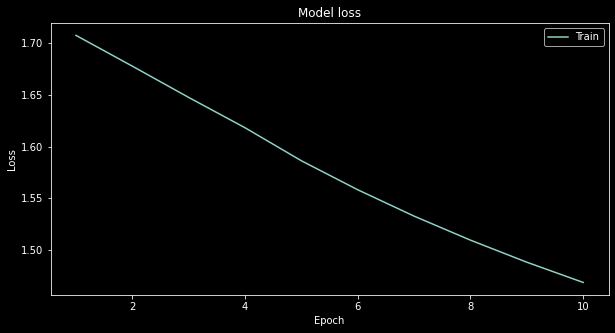

In [ ]:
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(list(range(1, epoches+1)),loss_list)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [ ]:
correct = 0
total = 0
# поскольку мы не обучаемся, нам не нужно вычислять градиенты для наших выходов
with torch.no_grad():
    for data in testloader:
        img, labels = data[0].to(device), data[1].to(device)
        # рассчитываем выходные данные, пропуская изображения через сеть
        outputs = net(img)
        # класс с наибольшей мощностью - это то, что мы выбираем в качестве предсказания
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 54 %


# Архитектура нейронки 2

In [ ]:
# Инициализация модели
class MyNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,64,4,stride=1)
        self.conv2 = nn.Conv2d(64,128,4,stride=1)
        self.conv3 = nn.Conv2d(128,256,4,stride=1)

        self.flatten = nn.Flatten()
        self.act = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(2,2)
        self.adaptivepool = nn.AdaptiveAvgPool2d((1,1))

        self.linear1 = nn.Linear(256,100)
        self.linear2 = nn.Linear(100,10)

    def forward(self, x):
      x=self.conv1(x)
      x=self.act(x)
      x=self.maxpool(x)

      x=self.conv2(x)
      x=self.act(x)
      x=self.maxpool(x)

      x=self.conv3(x)
      x=self.act(x)
      x=self.adaptivepool(x)

      x=self.flatten(x)
      x=self.linear1(x)
      x=self.act(x)
      x=self.linear2(x)

      return x

In [ ]:
net = MyNet2()
net.to(device)
summary(net,(3,64,64),batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [40, 64, 61, 61]           3,136
         LeakyReLU-2           [40, 64, 61, 61]               0
         MaxPool2d-3           [40, 64, 30, 30]               0
            Conv2d-4          [40, 128, 27, 27]         131,200
         LeakyReLU-5          [40, 128, 27, 27]               0
         MaxPool2d-6          [40, 128, 13, 13]               0
            Conv2d-7          [40, 256, 10, 10]         524,544
         LeakyReLU-8          [40, 256, 10, 10]               0
 AdaptiveAvgPool2d-9            [40, 256, 1, 1]               0
          Flatten-10                  [40, 256]               0
           Linear-11                  [40, 100]          25,700
        LeakyReLU-12                  [40, 100]               0
           Linear-13                   [40, 10]           1,010
Total params: 685,590
Trainable params:

# Обечение архитектуры 2

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

learning_rate = 0.0001

optimizer = torch.optim.Adam(net.parameters(),learning_rate)

epoches = 10

In [ ]:
loss_list=[]
for epoch in range(epoches):  # многократное прохождение по набору данных
    
    running_loss = 0.0
    loss_val = 0.0
    

    for i, data in enumerate(trainloader, 0):
        # получаем входные данные; данные - это список [inputs, labels].
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиенты параметров
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # вывести статистику обучения
        running_loss += loss.item()
        loss_val += loss.item()
        if i % 50 == 49:    # вывести каждые 2000 images
            print(f'[{epoch + 1}, {(i + 1)*batch_size:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0
    loss_list.append(loss_val/len(trainloader))

print('Finished Training')

[1,  2000] loss: 1.488
[1,  4000] loss: 1.457
[1,  6000] loss: 1.438
[1,  8000] loss: 1.443
[1, 10000] loss: 1.450
[1, 12000] loss: 1.417
[1, 14000] loss: 1.410
[2,  2000] loss: 1.357
[2,  4000] loss: 1.322
[2,  6000] loss: 1.360
[2,  8000] loss: 1.376
[2, 10000] loss: 1.340
[2, 12000] loss: 1.302
[2, 14000] loss: 1.338
[3,  2000] loss: 1.286
[3,  4000] loss: 1.248
[3,  6000] loss: 1.241
[3,  8000] loss: 1.278
[3, 10000] loss: 1.313
[3, 12000] loss: 1.331
[3, 14000] loss: 1.340
[4,  2000] loss: 1.291
[4,  4000] loss: 1.244
[4,  6000] loss: 1.256
[4,  8000] loss: 1.241
[4, 10000] loss: 1.164
[4, 12000] loss: 1.240
[4, 14000] loss: 1.214
[5,  2000] loss: 1.236
[5,  4000] loss: 1.170
[5,  6000] loss: 1.233
[5,  8000] loss: 1.154
[5, 10000] loss: 1.235
[5, 12000] loss: 1.205
[5, 14000] loss: 1.201
[6,  2000] loss: 1.164
[6,  4000] loss: 1.204
[6,  6000] loss: 1.168
[6,  8000] loss: 1.181
[6, 10000] loss: 1.124
[6, 12000] loss: 1.189
[6, 14000] loss: 1.157
[7,  2000] loss: 1.145
[7,  4000] 

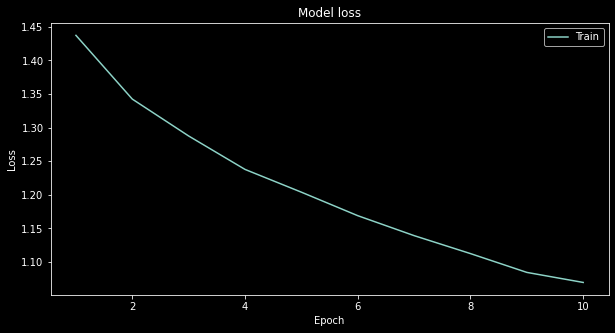

In [ ]:
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(list(range(1, epoches+1)),loss_list)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [ ]:
correct = 0
total = 0
# поскольку мы не обучаемся, нам не нужно вычислять градиенты для наших выходов
with torch.no_grad():
    for data in testloader:
        img, labels = data[0].to(device), data[1].to(device)
        # рассчитываем выходные данные, пропуская изображения через сеть
        outputs = net(img)
        # класс с наибольшей мощностью - это то, что мы выбираем в качестве предсказания
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 65 %


# Архитектура нейронки 3

In [ ]:
# Инициализация модели
class MyNet3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,64,3)
        self.conv2 = nn.Conv2d(64,128,3)
        self.conv3 = nn.Conv2d(128,256,3)
        self.conv4 = nn.Conv2d(256,512,3)

        self.flatten = nn.Flatten()
        self.act = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(2,2)
        self.adaptivepool = nn.AdaptiveAvgPool2d((1,1))

        self.linear1 = nn.Linear(512,256)
        self.linear2 = nn.Linear(256,100)
        self.linear3 = nn.Linear(100,10)
        

    def forward(self, x):
      x=self.conv1(x)
      x=self.act(x)
      x=self.maxpool(x)

      x=self.conv2(x)
      x=self.act(x)
      x=self.maxpool(x)

      x=self.conv3(x)
      x=self.act(x)
      x=self.maxpool(x)

      x=self.conv4(x)
      x=self.act(x)
      x=self.adaptivepool(x)

      x=self.flatten(x)
      x=self.linear1(x)
      x=self.act(x)
      x=self.linear2(x)
      x=self.act(x)
      x=self.linear3(x)
      x=F.log_softmax(x,dim=1)

      return x

In [ ]:
net = MyNet()
net.to(device)
summary(net,(3,64,64),batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [40, 64, 62, 62]           1,792
              ReLU-2           [40, 64, 62, 62]               0
         MaxPool2d-3           [40, 64, 31, 31]               0
            Conv2d-4          [40, 128, 29, 29]          73,856
              ReLU-5          [40, 128, 29, 29]               0
         MaxPool2d-6          [40, 128, 14, 14]               0
            Conv2d-7          [40, 256, 12, 12]         295,168
              ReLU-8          [40, 256, 12, 12]               0
         MaxPool2d-9            [40, 256, 6, 6]               0
           Conv2d-10            [40, 256, 4, 4]         590,080
             ReLU-11            [40, 256, 4, 4]               0
        MaxPool2d-12            [40, 256, 2, 2]               0
          Flatten-13                 [40, 1024]               0
           Linear-14                  [

# Обечение архитектуры 3

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

learning_rate = 0.0001

optimizer = torch.optim.Adam(net.parameters(),learning_rate)

epoches = 10

In [ ]:
loss_list=[]
for epoch in range(epoches):  # многократное прохождение по набору данных
    
    running_loss = 0.0
    loss_val = 0.0
    

    for i, data in enumerate(trainloader, 0):
        # получаем входные данные; данные - это список [inputs, labels].
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиенты параметров
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # вывести статистику обучения
        running_loss += loss.item()
        loss_val += loss.item()
        if i % 50 == 49:    # вывести каждые 2000 images
            print(f'[{epoch + 1}, {(i + 1)*batch_size:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0
    loss_list.append(loss_val/len(trainloader))

print('Finished Training')

[1,  2000] loss: 2.264
[1,  4000] loss: 2.025
[1,  6000] loss: 1.832
[1,  8000] loss: 1.743
[1, 10000] loss: 1.680
[1, 12000] loss: 1.678
[1, 14000] loss: 1.589
[2,  2000] loss: 1.615
[2,  4000] loss: 1.635
[2,  6000] loss: 1.606
[2,  8000] loss: 1.580
[2, 10000] loss: 1.553
[2, 12000] loss: 1.489
[2, 14000] loss: 1.487
[3,  2000] loss: 1.481
[3,  4000] loss: 1.442
[3,  6000] loss: 1.428
[3,  8000] loss: 1.459
[3, 10000] loss: 1.431
[3, 12000] loss: 1.359
[3, 14000] loss: 1.396
[4,  2000] loss: 1.366
[4,  4000] loss: 1.384
[4,  6000] loss: 1.330
[4,  8000] loss: 1.321
[4, 10000] loss: 1.328
[4, 12000] loss: 1.337
[4, 14000] loss: 1.306
[5,  2000] loss: 1.294
[5,  4000] loss: 1.278
[5,  6000] loss: 1.322
[5,  8000] loss: 1.256
[5, 10000] loss: 1.268
[5, 12000] loss: 1.216
[5, 14000] loss: 1.249
[6,  2000] loss: 1.216
[6,  4000] loss: 1.271
[6,  6000] loss: 1.221
[6,  8000] loss: 1.207
[6, 10000] loss: 1.189
[6, 12000] loss: 1.215
[6, 14000] loss: 1.195
[7,  2000] loss: 1.202
[7,  4000] 

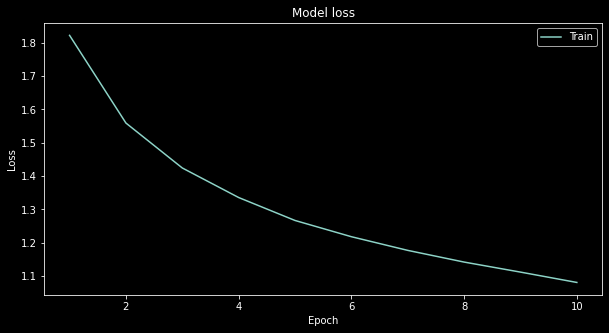

In [ ]:
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(list(range(1, epoches+1)),loss_list)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [ ]:
correct = 0
total = 0
# поскольку мы не обучаемся, нам не нужно вычислять градиенты для наших выходов
with torch.no_grad():
    for data in testloader:
        img, labels = data[0].to(device), data[1].to(device)
        # рассчитываем выходные данные, пропуская изображения через сеть
        outputs = net(img)
        # класс с наибольшей мощностью - это то, что мы выбираем в качестве предсказания
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 66 %


# Архитектура нейронки 4

In [ ]:
# Инициализация модели
class MyNet4(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,64,3)
        self.conv2 = nn.Conv2d(64,128,3)
        self.conv3 = nn.Conv2d(128,256,3)
        self.conv4 = nn.Conv2d(256,512,3)

        self.act1 = nn.ReLU()
        self.act2 = nn.LeakyReLU(0.2)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.15)

        self.linear1 = nn.Linear(2048,1024)
        self.linear2 = nn.Linear(1024,512)
        self.linear3 = nn.Linear(512,10)

    def forward(self, x):
      x=self.conv1(x)
      x=self.act1(x)
      x=self.maxpool(x)
      x=self.dropout(x)

      x=self.conv2(x)
      x=self.act2(x)
      x=self.maxpool(x)
      x=self.dropout(x)

      x=self.conv3(x)
      x=self.act1(x)
      x=self.maxpool(x)
      x=self.dropout(x)

      x=self.conv4(x)
      x=self.act2(x)
      x=self.maxpool(x)

      x=self.flatten(x)
      x=self.linear1(x)
      x=self.act1(x)
      x=self.linear2(x)
      x=self.act2(x)
      x=self.linear3(x)
      x=F.log_softmax(x,dim=1)

      return x

In [ ]:
net = MyNet4()
net.to(device)
summary(net,(3,64,64),batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [40, 64, 62, 62]           1,792
              ReLU-2           [40, 64, 62, 62]               0
         MaxPool2d-3           [40, 64, 31, 31]               0
           Dropout-4           [40, 64, 31, 31]               0
            Conv2d-5          [40, 128, 29, 29]          73,856
         LeakyReLU-6          [40, 128, 29, 29]               0
         MaxPool2d-7          [40, 128, 14, 14]               0
           Dropout-8          [40, 128, 14, 14]               0
            Conv2d-9          [40, 256, 12, 12]         295,168
             ReLU-10          [40, 256, 12, 12]               0
        MaxPool2d-11            [40, 256, 6, 6]               0
          Dropout-12            [40, 256, 6, 6]               0
           Conv2d-13            [40, 512, 4, 4]       1,180,160
        LeakyReLU-14            [40, 51

# Обечение архитектуры 4

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

learning_rate = 0.001

optimizer = torch.optim.Adam(net.parameters(),learning_rate)

epoches = 10

In [ ]:
loss_list=[]
for epoch in range(epoches):  # многократное прохождение по набору данных
    
    running_loss = 0.0
    loss_val = 0.0
    

    for i, data in enumerate(trainloader, 0):
        # получаем входные данные; данные - это список [inputs, labels].
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиенты параметров
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # вывести статистику обучения
        running_loss += loss.item()
        loss_val += loss.item()
        if i % 50 == 49:    # вывести каждые 2000 images
            print(f'[{epoch + 1}, {(i + 1)*batch_size:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0
    loss_list.append(loss_val/len(trainloader))

print('Finished Training')

[1,  2000] loss: 2.114
[1,  4000] loss: 1.823
[1,  6000] loss: 1.740
[1,  8000] loss: 1.700
[1, 10000] loss: 1.670
[1, 12000] loss: 1.548
[1, 14000] loss: 1.523
[2,  2000] loss: 1.434
[2,  4000] loss: 1.459
[2,  6000] loss: 1.379
[2,  8000] loss: 1.397
[2, 10000] loss: 1.394
[2, 12000] loss: 1.346
[2, 14000] loss: 1.291
[3,  2000] loss: 1.288
[3,  4000] loss: 1.231
[3,  6000] loss: 1.243
[3,  8000] loss: 1.165
[3, 10000] loss: 1.210
[3, 12000] loss: 1.268
[3, 14000] loss: 1.199
[4,  2000] loss: 1.094
[4,  4000] loss: 1.070
[4,  6000] loss: 1.073
[4,  8000] loss: 1.088
[4, 10000] loss: 1.116
[4, 12000] loss: 1.089
[4, 14000] loss: 1.049
[5,  2000] loss: 0.979
[5,  4000] loss: 0.982
[5,  6000] loss: 0.975
[5,  8000] loss: 0.977
[5, 10000] loss: 0.929
[5, 12000] loss: 0.959
[5, 14000] loss: 1.014
[6,  2000] loss: 0.853
[6,  4000] loss: 0.893
[6,  6000] loss: 0.811
[6,  8000] loss: 0.904
[6, 10000] loss: 0.866
[6, 12000] loss: 0.902
[6, 14000] loss: 0.890
[7,  2000] loss: 0.743
[7,  4000] 

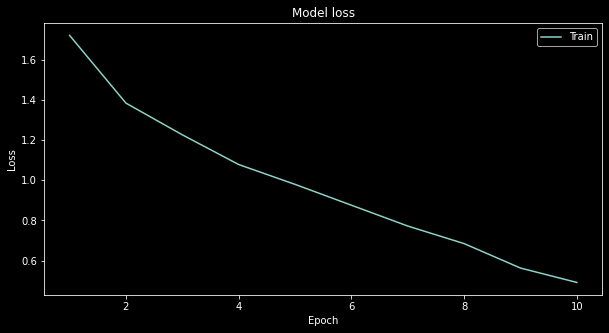

In [ ]:
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(list(range(1, epoches+1)),loss_list)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [ ]:
correct = 0
total = 0
# поскольку мы не обучаемся, нам не нужно вычислять градиенты для наших выходов
with torch.no_grad():
    for data in testloader:
        img, labels = data[0].to(device), data[1].to(device)
        # рассчитываем выходные данные, пропуская изображения через сеть
        outputs = net(img)
        # класс с наибольшей мощностью - это то, что мы выбираем в качестве предсказания
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 69 %


# Изменение оптимизатора

# SGD

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

learning_rate = 0.1

optimizer = torch.optim.SGD(net.parameters(),learning_rate)

epoches = 10

In [ ]:
loss_list=[]
for epoch in range(epoches):  # многократное прохождение по набору данных
    
    running_loss = 0.0
    loss_val = 0.0
    

    for i, data in enumerate(trainloader, 0):
        # получаем входные данные; данные - это список [inputs, labels].
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиенты параметров
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # вывести статистику обучения
        running_loss += loss.item()
        loss_val += loss.item()
        if i % 50 == 49:    # вывести каждые 2000 images
            print(f'[{epoch + 1}, {(i + 1)*batch_size:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0
    loss_list.append(loss_val/len(trainloader))

print('Finished Training')

[1,  2000] loss: 2.128
[1,  4000] loss: 2.023
[1,  6000] loss: 1.934
[1,  8000] loss: 1.850
[1, 10000] loss: 1.760
[1, 12000] loss: 1.747
[1, 14000] loss: 1.761
[2,  2000] loss: 1.666
[2,  4000] loss: 1.641
[2,  6000] loss: 1.670
[2,  8000] loss: 1.639
[2, 10000] loss: 1.623
[2, 12000] loss: 1.568
[2, 14000] loss: 1.592
[3,  2000] loss: 1.534
[3,  4000] loss: 1.554
[3,  6000] loss: 1.507
[3,  8000] loss: 1.529
[3, 10000] loss: 1.490
[3, 12000] loss: 1.463
[3, 14000] loss: 1.445
[4,  2000] loss: 1.418
[4,  4000] loss: 1.440
[4,  6000] loss: 1.467
[4,  8000] loss: 1.437
[4, 10000] loss: 1.452
[4, 12000] loss: 1.411
[4, 14000] loss: 1.356
[5,  2000] loss: 1.355
[5,  4000] loss: 1.390
[5,  6000] loss: 1.310
[5,  8000] loss: 1.326
[5, 10000] loss: 1.301
[5, 12000] loss: 1.281
[5, 14000] loss: 1.293
[6,  2000] loss: 1.302
[6,  4000] loss: 1.255
[6,  6000] loss: 1.265
[6,  8000] loss: 1.215
[6, 10000] loss: 1.225
[6, 12000] loss: 1.231
[6, 14000] loss: 1.201
[7,  2000] loss: 1.195
[7,  4000] 

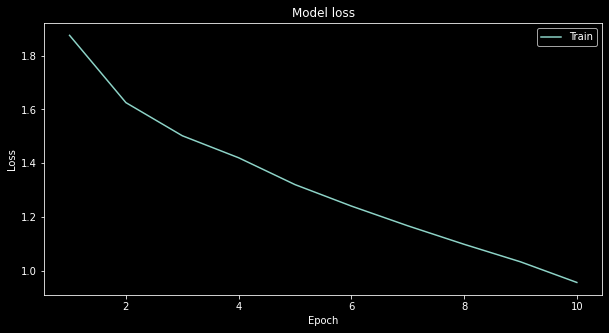

In [ ]:
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(list(range(1, epoches+1)),loss_list)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [ ]:
correct = 0
total = 0
# поскольку мы не обучаемся, нам не нужно вычислять градиенты для наших выходов
with torch.no_grad():
    for data in testloader:
        img, labels = data[0].to(device), data[1].to(device)
        # рассчитываем выходные данные, пропуская изображения через сеть
        outputs = net(img)
        # класс с наибольшей мощностью - это то, что мы выбираем в качестве предсказания
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 62 %


# RMSprop

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

learning_rate = 0.0001

optimizer = torch.optim.RMSprop(net.parameters(),learning_rate)

epoches = 10

In [ ]:
loss_list=[]
for epoch in range(epoches):  # многократное прохождение по набору данных
    
    running_loss = 0.0
    loss_val = 0.0
    

    for i, data in enumerate(trainloader, 0):
        # получаем входные данные; данные - это список [inputs, labels].
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиенты параметров
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # вывести статистику обучения
        running_loss += loss.item()
        loss_val += loss.item()
        if i % 50 == 49:    # вывести каждые 2000 images
            print(f'[{epoch + 1}, {(i + 1)*batch_size:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0
    loss_list.append(loss_val/len(trainloader))

print('Finished Training')

[1,  2000] loss: 2.091
[1,  4000] loss: 1.790
[1,  6000] loss: 1.715
[1,  8000] loss: 1.685
[1, 10000] loss: 1.608
[1, 12000] loss: 1.602
[1, 14000] loss: 1.545
[2,  2000] loss: 1.509
[2,  4000] loss: 1.478
[2,  6000] loss: 1.439
[2,  8000] loss: 1.393
[2, 10000] loss: 1.370
[2, 12000] loss: 1.384
[2, 14000] loss: 1.352
[3,  2000] loss: 1.283
[3,  4000] loss: 1.360
[3,  6000] loss: 1.295
[3,  8000] loss: 1.304
[3, 10000] loss: 1.316
[3, 12000] loss: 1.310
[3, 14000] loss: 1.256
[4,  2000] loss: 1.230
[4,  4000] loss: 1.228
[4,  6000] loss: 1.244
[4,  8000] loss: 1.230
[4, 10000] loss: 1.217
[4, 12000] loss: 1.242
[4, 14000] loss: 1.187
[5,  2000] loss: 1.176
[5,  4000] loss: 1.211
[5,  6000] loss: 1.189
[5,  8000] loss: 1.160
[5, 10000] loss: 1.145
[5, 12000] loss: 1.164
[5, 14000] loss: 1.172
[6,  2000] loss: 1.077
[6,  4000] loss: 1.151
[6,  6000] loss: 1.095
[6,  8000] loss: 1.154
[6, 10000] loss: 1.117
[6, 12000] loss: 1.124
[6, 14000] loss: 1.089
[7,  2000] loss: 1.002
[7,  4000] 

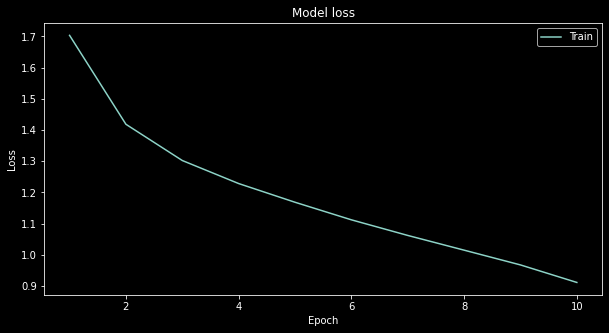

In [ ]:
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(list(range(1, epoches+1)),loss_list)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [ ]:
correct = 0
total = 0
# поскольку мы не обучаемся, нам не нужно вычислять градиенты для наших выходов
with torch.no_grad():
    for data in testloader:
        img, labels = data[0].to(device), data[1].to(device)
        # рассчитываем выходные данные, пропуская изображения через сеть
        outputs = net(img)
        # класс с наибольшей мощностью - это то, что мы выбираем в качестве предсказания
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 66 %


# Adagrad

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

learning_rate = 0.001

optimizer = torch.optim.Adagrad(net.parameters(),learning_rate)

epoches = 10

In [ ]:
loss_list=[]
for epoch in range(epoches):  # многократное прохождение по набору данных
    
    running_loss = 0.0
    loss_val = 0.0
    

    for i, data in enumerate(trainloader, 0):
        # получаем входные данные; данные - это список [inputs, labels].
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиенты параметров
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # вывести статистику обучения
        running_loss += loss.item()
        loss_val += loss.item()
        if i % 50 == 49:    # вывести каждые 2000 images
            print(f'[{epoch + 1}, {(i + 1)*batch_size:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0
    loss_list.append(loss_val/len(trainloader))

print('Finished Training')

[1,  2000] loss: 2.112
[1,  4000] loss: 1.857
[1,  6000] loss: 1.785
[1,  8000] loss: 1.702
[1, 10000] loss: 1.671
[1, 12000] loss: 1.617
[1, 14000] loss: 1.536
[2,  2000] loss: 1.477
[2,  4000] loss: 1.462
[2,  6000] loss: 1.480
[2,  8000] loss: 1.483
[2, 10000] loss: 1.439
[2, 12000] loss: 1.408
[2, 14000] loss: 1.403
[3,  2000] loss: 1.377
[3,  4000] loss: 1.386
[3,  6000] loss: 1.363
[3,  8000] loss: 1.342
[3, 10000] loss: 1.350
[3, 12000] loss: 1.336
[3, 14000] loss: 1.327
[4,  2000] loss: 1.339
[4,  4000] loss: 1.272
[4,  6000] loss: 1.309
[4,  8000] loss: 1.299
[4, 10000] loss: 1.237
[4, 12000] loss: 1.335
[4, 14000] loss: 1.270
[5,  2000] loss: 1.245
[5,  4000] loss: 1.289
[5,  6000] loss: 1.251
[5,  8000] loss: 1.261
[5, 10000] loss: 1.285
[5, 12000] loss: 1.233
[5, 14000] loss: 1.254
[6,  2000] loss: 1.225
[6,  4000] loss: 1.250
[6,  6000] loss: 1.229
[6,  8000] loss: 1.215
[6, 10000] loss: 1.225
[6, 12000] loss: 1.184
[6, 14000] loss: 1.234
[7,  2000] loss: 1.249
[7,  4000] 

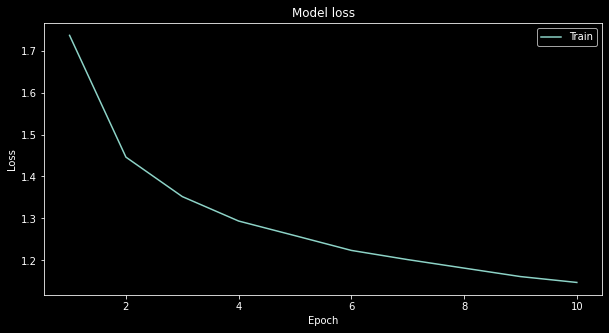

In [ ]:
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(list(range(1, epoches+1)),loss_list)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [ ]:
correct = 0
total = 0
# поскольку мы не обучаемся, нам не нужно вычислять градиенты для наших выходов
with torch.no_grad():
    for data in testloader:
        img, labels = data[0].to(device), data[1].to(device)
        # рассчитываем выходные данные, пропуская изображения через сеть
        outputs = net(img)
        # класс с наибольшей мощностью - это то, что мы выбираем в качестве предсказания
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 62 %
